In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomTranslation
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.losses import sparse_categorical_crossentropy

from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Recall
from tensorflow.keras.models import load_model

from keras.preprocessing.image import ImageDataGenerator


import pickle

2023-04-27 15:39:10.392610: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 15:39:10.727927: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-27 15:39:10.798623: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-27 15:39:10.798642: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

# Import file

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [3]:
y_train = train["label"]
X_train = train.drop("label",axis= 1) / 255

X_test = test /255

In [4]:
test

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Visualize numbers

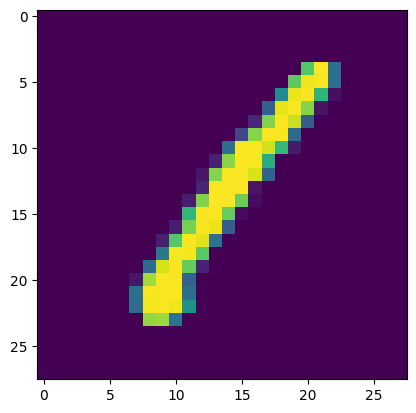

In [5]:
plt.imshow(X_train.loc[0].values.reshape(28,28))

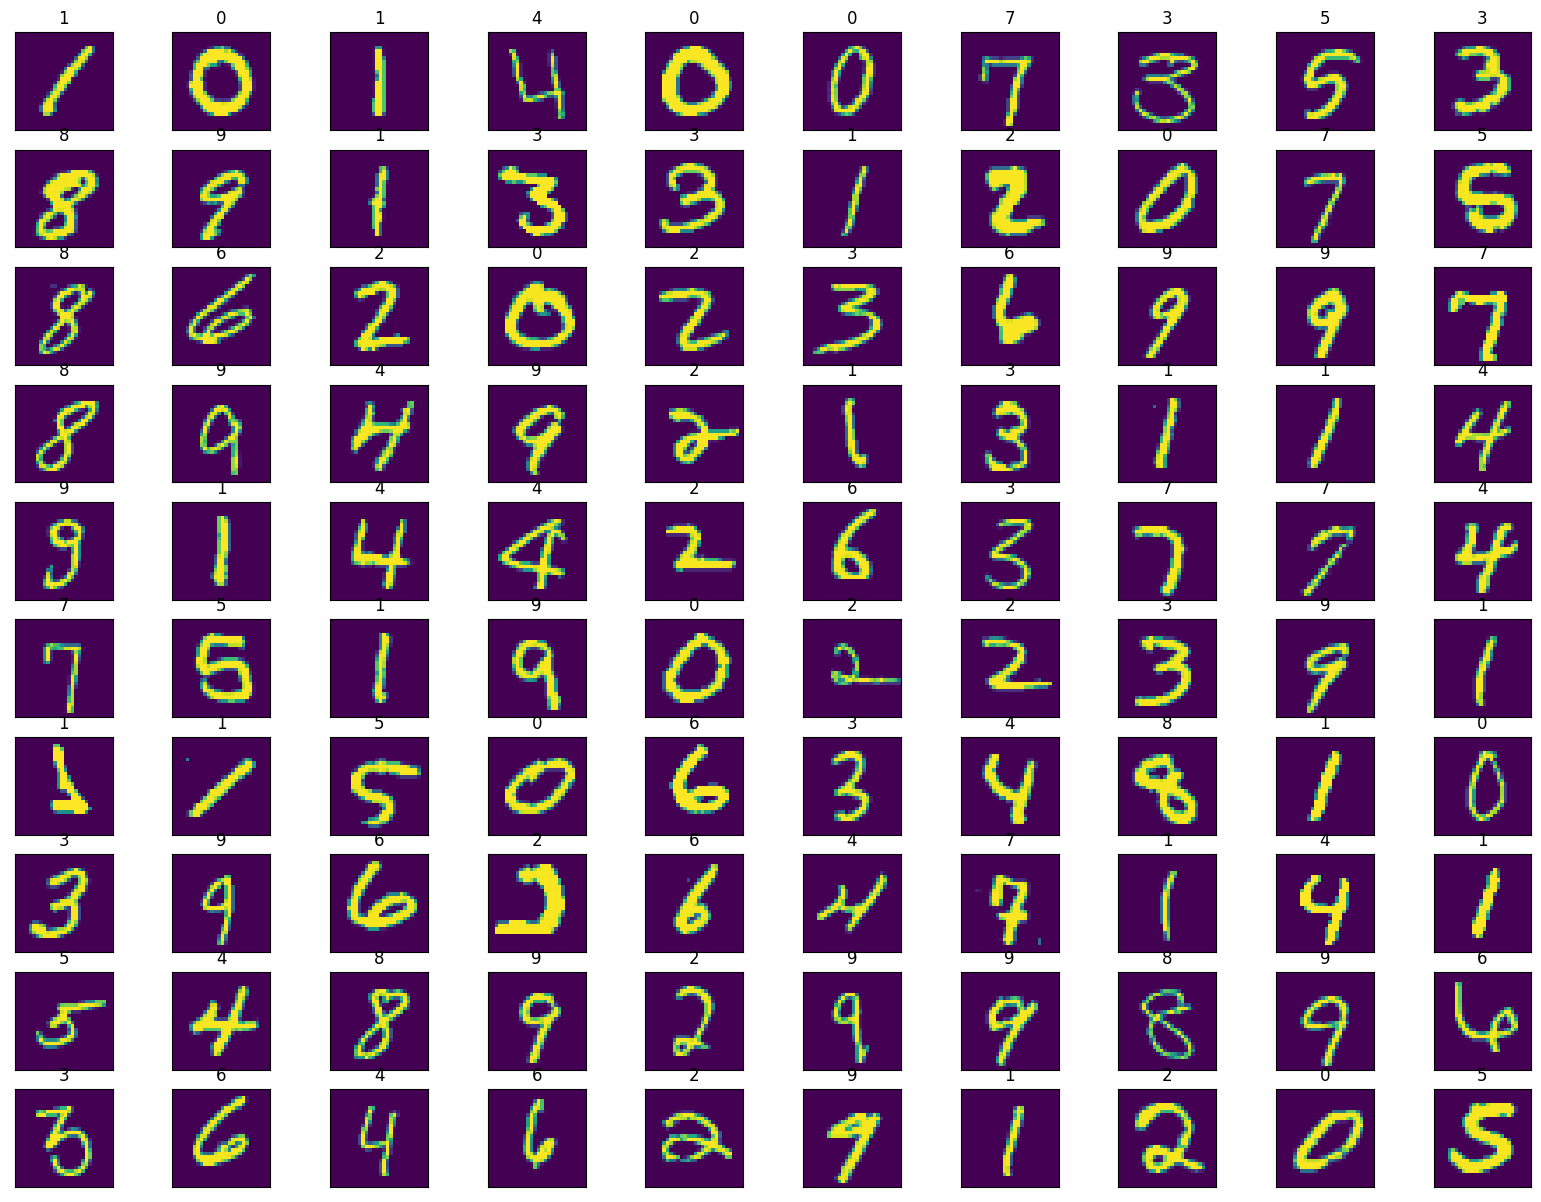

In [6]:
fig, ax = plt.subplots(10, 10, figsize=(20, 15))
for i,ax in enumerate(ax.flat) :
    ax.imshow(X_train.loc[i].values.reshape(28,28))
    ax.set(xticks=[], yticks=[], title= y_train[i])

# Model

In [7]:
def learning_curve_dl(history, metric):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history[metric])
    plt.plot(history.history[f"val_{metric}"])
    plt.title(f'model {metric}')
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## Baseline

2023-04-27 15:39:19.643085: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-27 15:39:19.643284: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-27 15:39:19.643333: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-04-27 15:39:19.643412: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-04-27 15:39:19.643452: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

Epoch 1/20
55/55 [==============================] - 1s 11ms/step - loss: 0.5968 - sparse_categorical_accuracy: 0.8410 - val_loss: 0.2662 - val_sparse_categorical_accuracy: 0.9196
Epoch 2/20
55/55 [==============================] - 0s 8ms/step - loss: 0.2196 - sparse_categorical_accuracy: 0.9351 - val_loss: 0.1811 - val_sparse_categorical_accuracy: 0.9481
Epoch 3/20
55/55 [==============================] - 0s 8ms/step - loss: 0.1540 - sparse_categorical_accuracy: 0.9559 - val_loss: 0.1500 - val_sparse_categorical_accuracy: 0.9557
Epoch 4/20
55/55 [==============================] - 0s 8ms/step - loss: 0.1170 - sparse_categorical_accuracy: 0.9663 - val_loss: 0.1348 - val_sparse_categorical_accuracy: 0.9592
Epoch 5/20
55/55 [==============================] - 0s 8ms/step - loss: 0.0937 - sparse_categorical_accuracy: 0.9724 - val_loss: 0.1194 - val_sparse_categorical_accuracy: 0.9642
Epoch 6/20
55/55 [==============================] - 0s 9ms/step - loss: 0.0724 - sparse_categorical_accuracy:

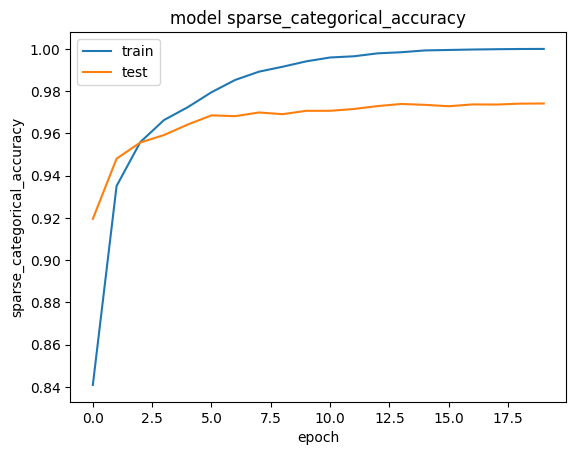

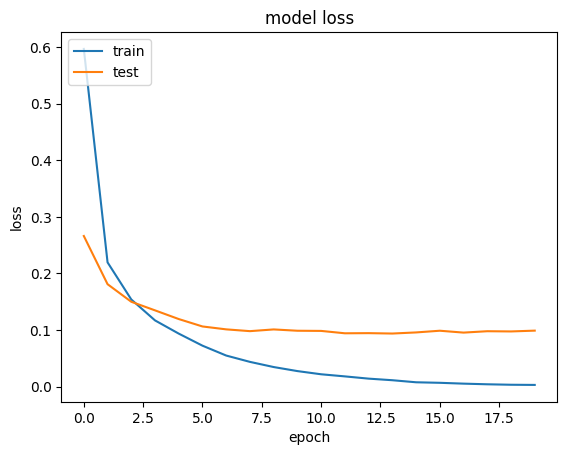

In [8]:
model = Sequential()
model.add(Input(784))
# model.add(Flatten(input_shape = (28,28)))
# model.add(RandomFlip("horizontal"))
# model.add(RandomRotation(0.1))
model.add(Dense(397, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile model
model.compile(loss = sparse_categorical_crossentropy, optimizer='adam', metrics=["sparse_categorical_accuracy"])

# Fit the model
history = model.fit(x = X_train, y = y_train,epochs=20, batch_size= 512, validation_split= 0.33 )

# Save model
model.save("data/model_baseline.h5")

learning_curve_dl(history,"sparse_categorical_accuracy")

In [9]:
X_train.values.reshape(X_train.shape[0], 28, 28, 1)

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

## Convolutional

## 1 conv layer, 21000 data augmentation

Epoch 1/20
220/220 [==============================] - 4s 15ms/step - loss: 0.4523 - accuracy: 0.8622 - val_loss: 0.2045 - val_accuracy: 0.9406
Epoch 2/20
220/220 [==============================] - 3s 14ms/step - loss: 0.1457 - accuracy: 0.9578 - val_loss: 0.1435 - val_accuracy: 0.9553
Epoch 3/20
220/220 [==============================] - 3s 14ms/step - loss: 0.0890 - accuracy: 0.9743 - val_loss: 0.1121 - val_accuracy: 0.9676
Epoch 4/20
220/220 [==============================] - 3s 14ms/step - loss: 0.0606 - accuracy: 0.9822 - val_loss: 0.0939 - val_accuracy: 0.9716
Epoch 5/20
220/220 [==============================] - 3s 14ms/step - loss: 0.0424 - accuracy: 0.9879 - val_loss: 0.0875 - val_accuracy: 0.9735
Epoch 6/20
220/220 [==============================] - 3s 14ms/step - loss: 0.0308 - accuracy: 0.9912 - val_loss: 0.0803 - val_accuracy: 0.9753
Epoch 7/20
220/220 [==============================] - 3s 14ms/step - loss: 0.0229 - accuracy: 0.9935 - val_loss: 0.0896 - val_accuracy: 0.9740

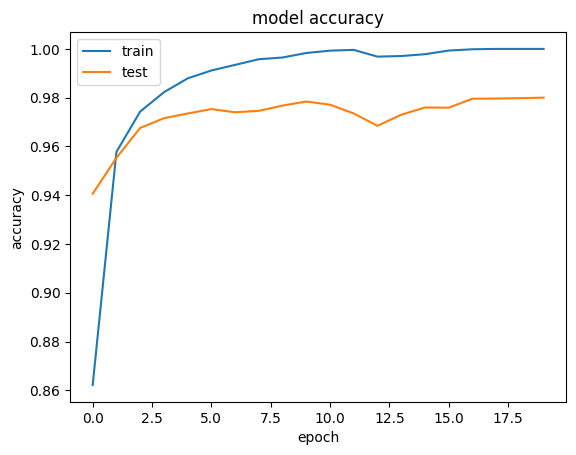

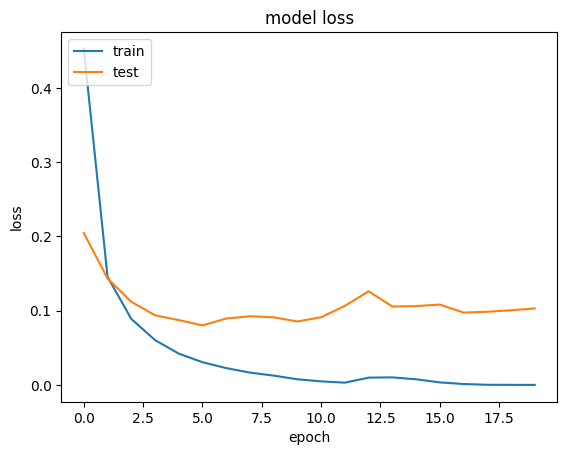

In [10]:
# Reshape the input data to 4D tensor with shape (batch_size, rows, columns, channels)
x_train = X_train.values.reshape(X_train.shape[0], 28, 28, 1)

# Create a data generator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,      # randomly rotate the images by up to 10 degrees
    zoom_range=0.1,         # randomly zoom the images by up to 10%
    width_shift_range=0.1,  # randomly shift the images horizontally by up to 10%
    height_shift_range=0.1, # randomly shift the images vertically by up to 10%
    horizontal_flip=True,   # randomly flip the images horizontally
    vertical_flip=False,    # don't randomly flip the images vertically
    fill_mode='nearest'     # fill any empty pixels with the nearest value
)

# Fit the data generator to the training data
datagen.fit(x_train)

# Generate augmented data

augmented_data = datagen.flow(x_train, y_train, batch_size= 21000)

# Concatenate original and augmented data
x_train_augmented = np.concatenate([x_train, augmented_data[0][0]], axis=0).reshape(63000,784)
y_train_augmented = np.concatenate([y_train, augmented_data[0][1]], axis=0)

model = Sequential()
# model.add(Input(784))
model.add(Conv2D(32, (3,3), activation = 'relu', input_shape=(28, 28, 1))) 
model.add(Flatten())
# model.add(RandomFlip("horizontal"))
# model.add(RandomRotation(0.1))

model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile model
model.compile(loss = sparse_categorical_crossentropy, optimizer='adam', metrics=["accuracy"])

# Fit the model
history = model.fit(x = x_train, y = y_train, epochs=20, validation_split= 0.33,batch_size = 128 )

# Save model
model.save("data/model_conv_ad.h5")

learning_curve_dl(history,"accuracy")

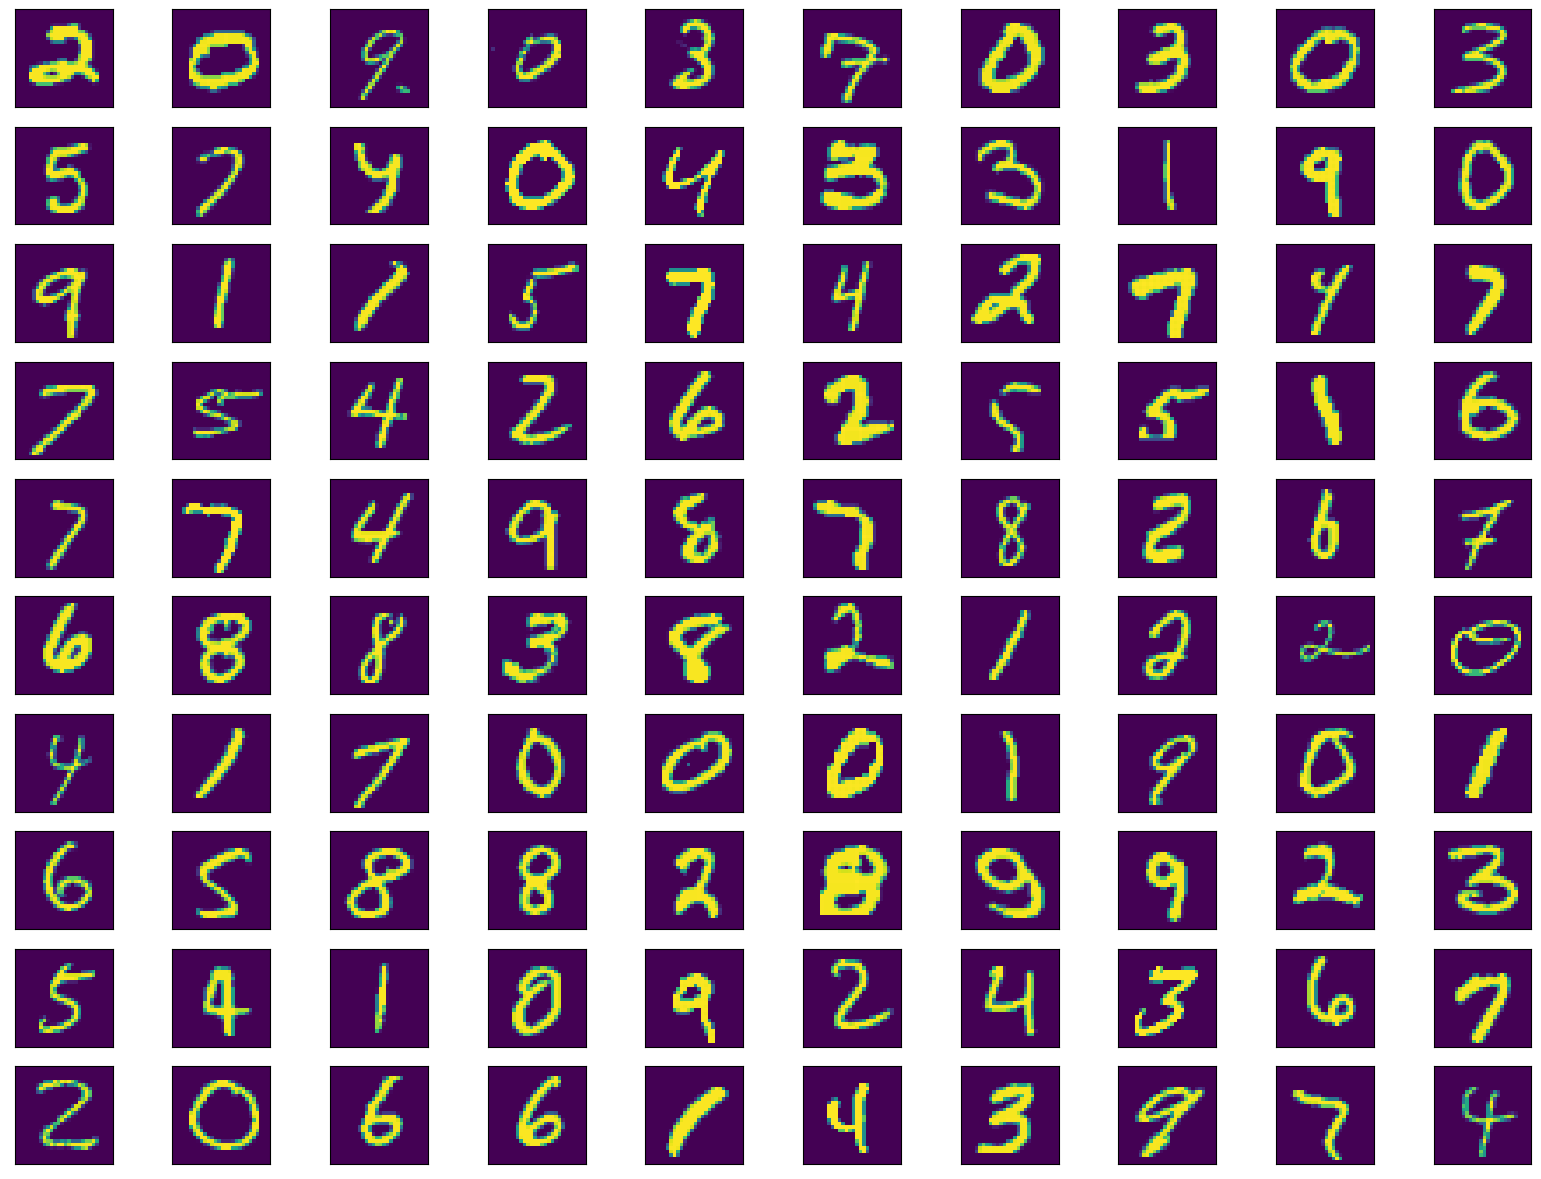

In [11]:
fig, ax = plt.subplots(10, 10, figsize=(20, 15))
for i,ax in enumerate(ax.flat) :
    ax.imshow(test.loc[i].values.reshape(28,28))
    ax.set(xticks=[], yticks=[])

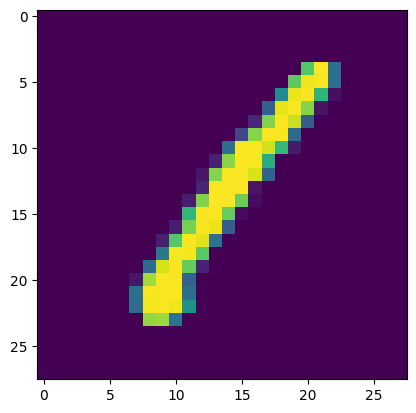

In [12]:
plt.imshow(X_train[::5].loc[0].values.reshape(28,28))

## 

Epoch 1/10
154/154 [==============================] - 7s 40ms/step - loss: 1.3337 - accuracy: 0.5064 - val_loss: 1.2909 - val_accuracy: 0.5492
Epoch 2/10
154/154 [==============================] - 7s 44ms/step - loss: 1.2024 - accuracy: 0.5495 - val_loss: 1.1880 - val_accuracy: 0.5551
Epoch 3/10
154/154 [==============================] - 7s 46ms/step - loss: 1.1809 - accuracy: 0.5570 - val_loss: 1.1776 - val_accuracy: 0.5567
Epoch 4/10
154/154 [==============================] - 7s 47ms/step - loss: 1.1697 - accuracy: 0.5623 - val_loss: 1.1678 - val_accuracy: 0.5618
Epoch 5/10
154/154 [==============================] - 7s 46ms/step - loss: 1.1606 - accuracy: 0.5649 - val_loss: 1.1729 - val_accuracy: 0.5589
Epoch 6/10
154/154 [==============================] - 7s 46ms/step - loss: 1.1544 - accuracy: 0.5680 - val_loss: 1.1670 - val_accuracy: 0.5625
Epoch 7/10
154/154 [==============================] - 7s 48ms/step - loss: 1.1463 - accuracy: 0.5693 - val_loss: 1.1641 - val_accuracy: 0.5636

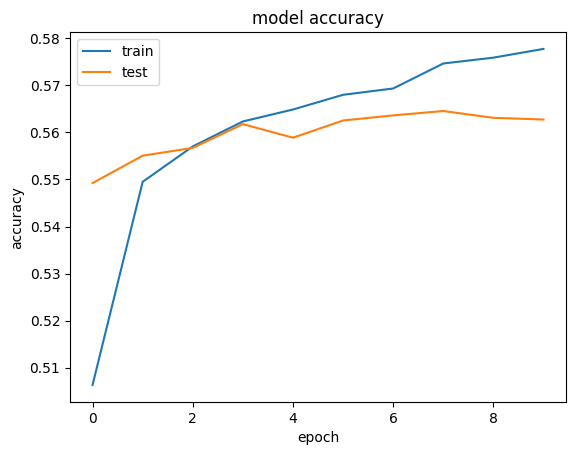

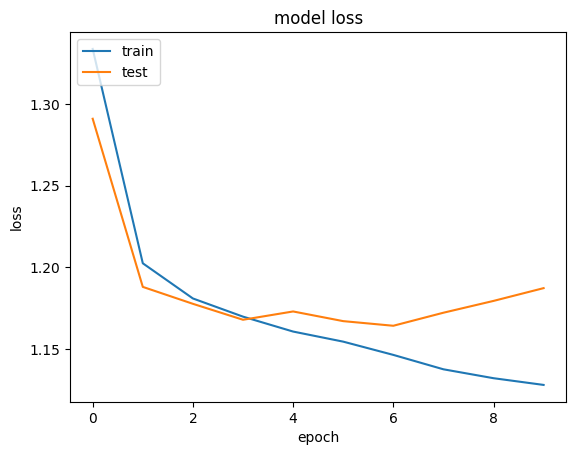

788/788 [==============================] - 3s 4ms/step
              precision    recall  f1-score   support

           0       0.45      0.63      0.53      2497
           1       0.29      0.84      0.43      2718
           2       0.81      0.49      0.61      2550
           3       0.90      0.52      0.66      2602
           4       0.71      0.53      0.61      2398
           5       0.95      0.49      0.64      2255
           6       0.79      0.50      0.61      2522
           7       0.61      0.57      0.59      2641
           8       0.55      0.54      0.55      2427
           9       0.94      0.49      0.65      2590

    accuracy                           0.56     25200
   macro avg       0.70      0.56      0.59     25200
weighted avg       0.70      0.56      0.59     25200



In [28]:
# Reshape the input data to 4D tensor with shape (batch_size, rows, columns, channels)
x_train = X_train.values.reshape(X_train.shape[0], 28, 28, 1)

# Create a data generator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=45,      # randomly rotate the images by up to 10 degrees
    zoom_range=30,         # randomly zoom the images by up to 10%
    width_shift_range=0.2,  # randomly shift the images horizontally by up to 10%
    height_shift_range=0.2, # randomly shift the images vertically by up to 10%
    horizontal_flip=True,   # randomly flip the images horizontally
    vertical_flip=False,    # don't randomly flip the images vertically
    fill_mode='nearest'     # fill any empty pixels with the nearest value
)

# Fit the data generator to the training data
datagen.fit(x_train)

# Generate augmented data

augmented_data = datagen.flow(x_train, y_train, batch_size= 42000)

# Concatenate original and augmented data
x_train_augmented = np.concatenate([x_train, augmented_data[0][0]], axis=0).reshape(84000,784)
y_train_augmented = np.concatenate([y_train, augmented_data[0][1]], axis=0)



X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(x_train_augmented, y_train_augmented, test_size=.3, random_state=1)

model = Sequential()
# model.add(Input(784))
model.add(BatchNormalization(input_shape=(28, 28, 1)))
model.add(Conv2D(32, (3,3), activation = 'relu')) 
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation = 'relu')) 
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation = 'relu')) 
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile model
model.compile(loss = sparse_categorical_crossentropy, optimizer='adam', metrics=["accuracy"])

# Fit the model
history = model.fit(x = X_train_split.reshape(58800,28,28,1), y = y_train_split, epochs=10, validation_split= 0.33,batch_size = 256 )

# Save model
model.save("data/model_conv_ad_norm.h5")

learning_curve_dl(history,"accuracy")

y_pred = model.predict(X_test_split.reshape(25200,28,28))
y_pred_classes = np.argmax(y_pred, axis = 1)
y_true = y_test_split.astype(int).tolist() # Returns the indices of the maximum values along an axis.
#confusion = confusion_matrix(y_true, y_pred_classes)
print(classification_report(y_true, y_pred_classes))

In [23]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_2 (Batc  (None, 28, 28, 1)        4         
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                      